# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np
import re
from datetime import datetime as dt
import timeit as ti
import pandas as pd
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.colors as plc

In [2]:
np.random.seed(499)
rmse = lambda y,a: mse(y,a,squared=False)
df = pd.read_csv("/datasets/autos.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Имена колонок приведены к snake_case

In [3]:
df.columns  = df.columns.map( lambda string: re.sub(r'(.)([A-Z])',r'\1_\2', string ).lower())
nan_cols = [ c for c in df.columns if df[c].isna().sum()>0 ]
df.head(60)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Заполнение пустых значений

In [4]:
for c in nan_cols:
    print(f"---- {c} ----- {df[c].isna().sum()} nulls ---- {round(df[c].isna().sum()/df[c].count()*100,1)}% ")
    print(df[c].value_counts().head(10))

---- vehicle_type ----- 37490 nulls ---- 11.8% 
vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64
---- gearbox ----- 19833 nulls ---- 5.9% 
gearbox
manual    268251
auto       66285
Name: count, dtype: int64
---- model ----- 19705 nulls ---- 5.9% 
model
golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: count, dtype: int64
---- fuel_type ----- 32895 nulls ---- 10.2% 
fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64
---- repaired ----- 71154 nulls ---- 25.1% 
repaired
no     247161
yes     36054
Name: count, dtype: int64


Для признаков <i>vehicle_type, fuel_type , gearbox</i> пропущенные значения естественно заменить модой c группировкой по модели  и году выпуска.   
Для признаков <i>repaired и model</i> полезной замены не видно, поэтому они будут заменены на <i>other</i>  

In [5]:
%%time
df[['repaired','model']] = df[['repaired','model']].fillna('other')
year_cols =['model','registration_year']
fix_nan_cols = ['vehicle_type','fuel_type','gearbox']
modes_by_year =  df.groupby(year_cols)[fix_nan_cols].agg(pd.Series.mode)
modes_by_model =  df.groupby('model')[fix_nan_cols].agg(pd.Series.mode)

def replace_nan_by_mode(row):
    new_values = {}
    for col in fix_nan_cols:
        if isinstance(row[col],str) :
            new_values[col]=row[col]
            continue
        try:
            new_values[col] =  modes_by_year.loc[ tuple( row[year_cols] ),col ]
            if isinstance(new_values[col],str):
                continue
            elif    len(new_values[col]) == 0:
                new_values[col] = modes_by_model.loc[ row['model'],col ]
            elif len(new_values[col])>1:
                new_values[col] = new_values[col][0]       
        except:
            new_values[col] = 'unknown'    
        if len(new_values[col])>1 and not isinstance(row[col],str) :
            new_values[col] = new_values[col][0]       

    return( new_values )    
    
df[fix_nan_cols] = df.apply(replace_nan_by_mode,axis=1,result_type='expand')

CPU times: total: 1min 23s
Wall time: 1min 23s


В колонке <i>number_of_pictures</i> только нули,  в таком виде она бесполезна и должна быть удалена 

In [6]:
df = df.drop('number_of_pictures',axis=1)

Приложение создается для новых клиентов, для них не имеют смысла  признаки длительности пребывания  в продаже <i>date_crawled,date_created,last_seen </i>  
Поэтому эти признаки нужно удалить 

In [7]:
date_cols = ['date_crawled','date_created','last_seen']
df = df.drop(date_cols,axis=1)

И после удаления лишних признаков провести дедупликацию

In [8]:
print( df.duplicated().sum( ) )
df = df.drop_duplicates()

22404


### Проверка корреляции

In [9]:
df.corr(numeric_only=True)

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.026678,0.154018,-0.328296,0.109751,0.081010
registration_year,0.026678,1.000000,-0.000745,-0.052515,-0.011159,-0.003086
power,0.154018,-0.000745,1.000000,0.024602,0.042394,0.022191
kilometer,-0.328296,-0.052515,0.024602,1.000000,0.012479,-0.011256
registration_month,0.109751,-0.011159,0.042394,0.012479,1.000000,0.015978
postal_code,0.081010,-0.003086,0.022191,-0.011256,0.015978,1.000000


Зависимостей не найдено

###  Проверка аномалий

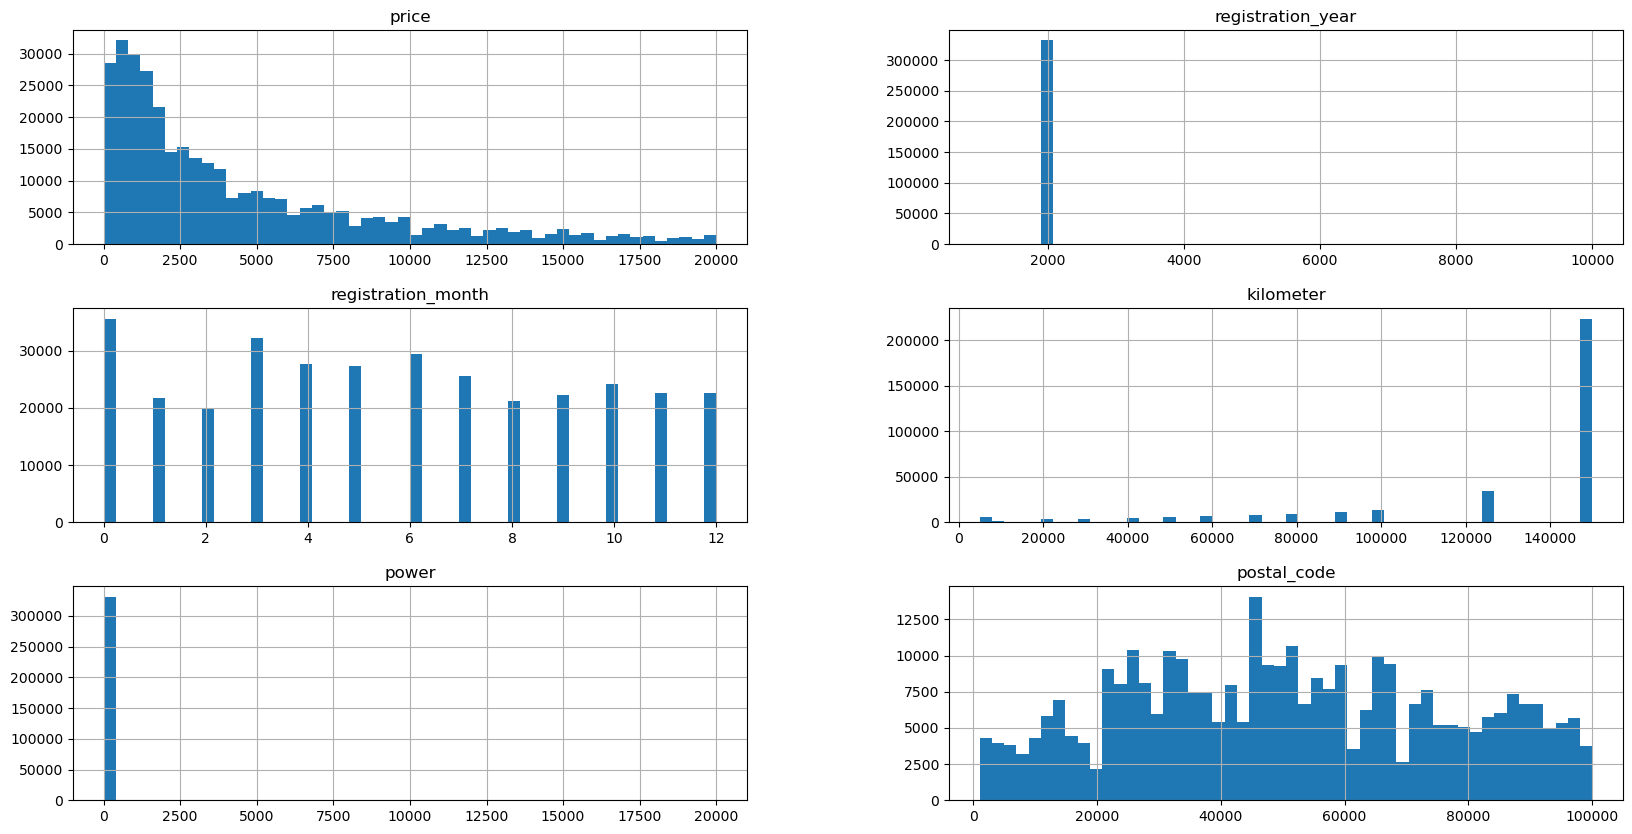

In [10]:
df[['price','registration_year','registration_month','kilometer','power','postal_code']] \
.hist(bins=50,figsize = (20,10) );

Из гистограмм видно, что на выбросы надо проверить пробег, мощность и дату регистрации<br>
Кроме того , месяц регистрации точно  содержит нули, цена также может содержать нули  


#### Аномалии цены

In [11]:
print(f"Найдено {(df.price<=0).sum()} записей с нулевой ценой или {round(100*(df.price<=0).sum()/df.shape[0],1)} %" )

Найдено 9935 записей с нулевой ценой или 3.0 %


Цена сделки не может быть равна нулю, во всяком случае это не коммерческая сделка и она нам не интересна.<br>
Так как эти строки не содержат никакой информации о целевом признаке, их придется удалить  </br>
Нулевой месяц лучше оставить как есть, так как это неопределенное значение все равно надо чем-то заполнять и подходящей замены не видно   


In [12]:
df = df[df.price>0]

#### Аномалии по году регистрации

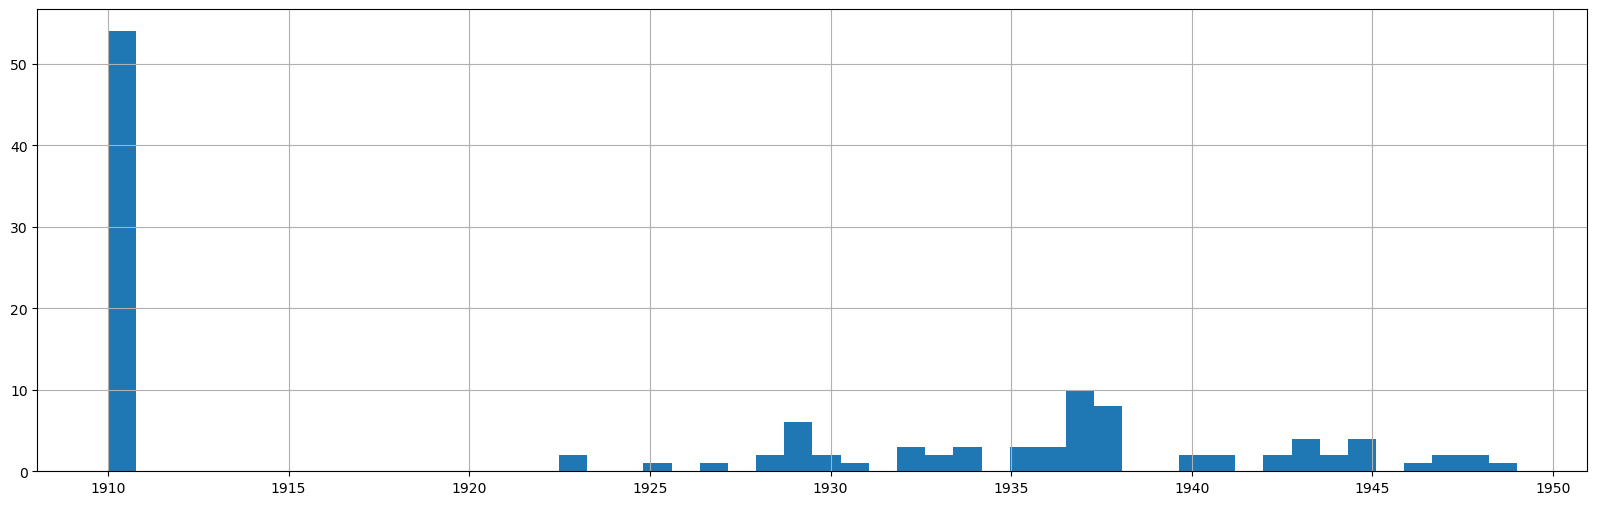

In [13]:
(df[(1900<df.registration_year) & (df.registration_year<1950)]).registration_year.hist(bins= 50 ,figsize= [20,6] );

Даты в интервале 1920 - 1950  выглядят как реальные 

In [14]:
print(f"Всего {(df.registration_year>2023).sum()} дат после сегодняшней , из них")
print(f"{((df.registration_year>2023)&(df.registration_month==0)&(df.power==0)).sum()} с нулевой мощностью и месяцем")
print(f"Всего {(df.registration_year<1920).sum()} очень старых дат сегодняшней , из них")
print(f"{((df.registration_year<1920)&(df.registration_month==0)&(df.power==0)).sum()} с нулевой мощностью и месяцем")
df[(df.registration_year>2023)].sort_values(by='registration_year')


Всего 82 дат после сегодняшней , из них
53 с нулевой мощностью и месяцем
Всего 105 очень старых дат сегодняшней , из них
73 с нулевой мощностью и месяцем


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
26560,800,b,2066,m,0,zafira,5000,0,gasoline,opel,other,45355
18259,300,s,2200,m,0,twingo,5000,12,p,renault,other,45307
220638,100,s,2222,m,0,other,5000,0,p,sonstige_autos,other,66538
121506,700,w,2290,m,0,laguna,5000,0,p,renault,other,63069
139756,3500,s,2500,m,0,other,5000,0,gasoline,volkswagen,other,33699
...,...,...,...,...,...,...,...,...,...,...,...,...
217111,850,s,9999,m,0,3er,10000,0,petrol,bmw,no,77746
200525,850,s,9999,m,0,other,10000,0,p,mazda,other,40822
167937,1000,s,9999,m,0,other,10000,0,p,mazda,other,40822
306578,350,s,9999,m,0,kaefer,10000,1,p,volkswagen,other,27432


У большинства записей с неадекватными датами <br>
 так же нулевой месяц регистрации и аномальная мощность <br>
Похоже они серьезно испорчены и их всего меньше 0.1%, так что их лучше удалить


 Записи с регистрацией 2016 составляют 2.7 % набора


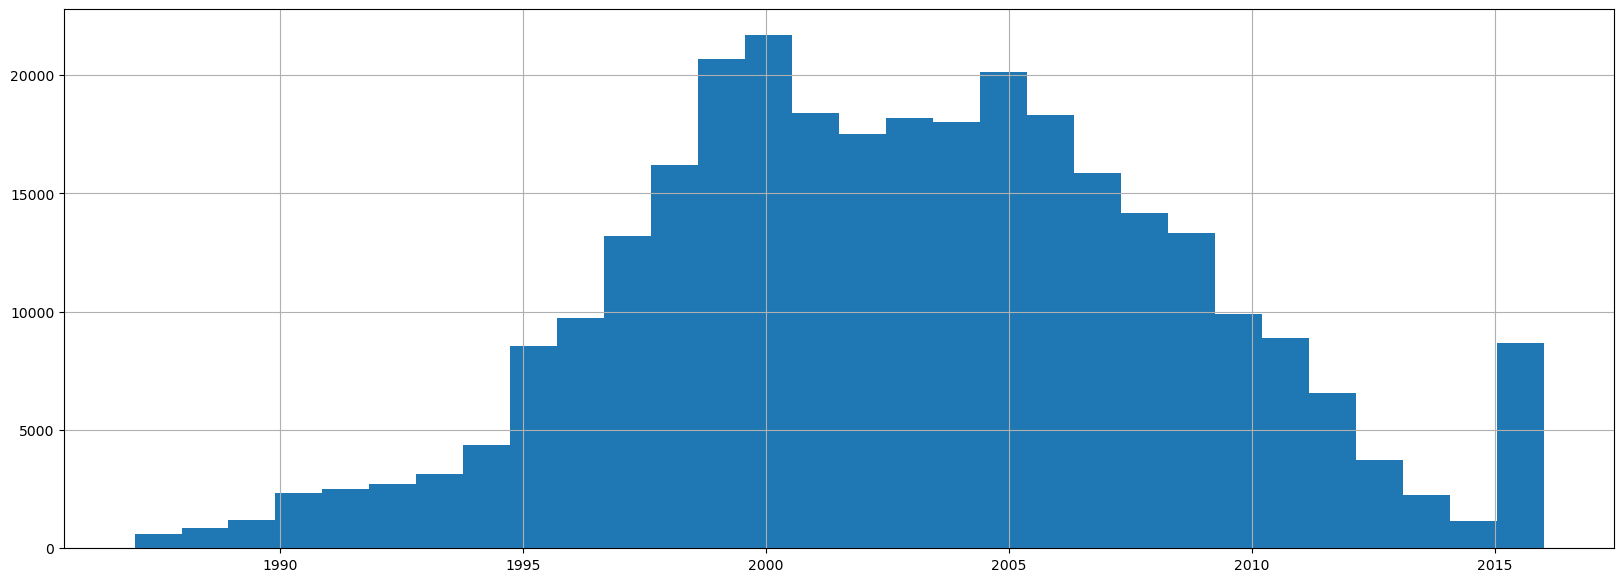

In [15]:
df[(df.registration_year<2017) & (df.registration_year>=1987)].registration_year.hist(bins=30,figsize=(20,7)) ;
print(f" Записи с регистрацией 2016 составляют {(df.registration_year==2016).sum()/df.shape[0]*100:.1f} % набора")

Есть выброc по количеству значений c регистрацией за 2016 год.  <br>
Так большинство записей попало в базу в марте, то у всех записей с регистрацией 2016 года в апреле и позже дата регистрации испорчена<br>
Скачок по аггрегированным числовым признакам (особенно заметный по медиане цены и среднему пробегу) также показывает чужеродность данных с регистрацией 2016 

price                      power                    \
                    median          mean count median        mean count   
registration_year                                                         
2013               12950.0  12792.964019  3752  105.0  111.582889  3752   
2014               13900.0  13218.282446  2273  105.0  108.548174  2273   
2015               12999.0  11436.023952  1169   94.0   94.434559  1169   
2016                1000.0   2241.544585  8680   75.0   79.888710  8680   
2017                1900.0   3179.866836  9447   80.0   88.987827  9447   

                  kilometer                       
                     median           mean count  
registration_year                                 
2013                40000.0   51961.620469  3752  
2014                30000.0   31849.978003  2273  
2015                10000.0   18622.754491  1169  
2016               150000.0  134165.322581  8680  
2017               150000.0  133395.257754  9447

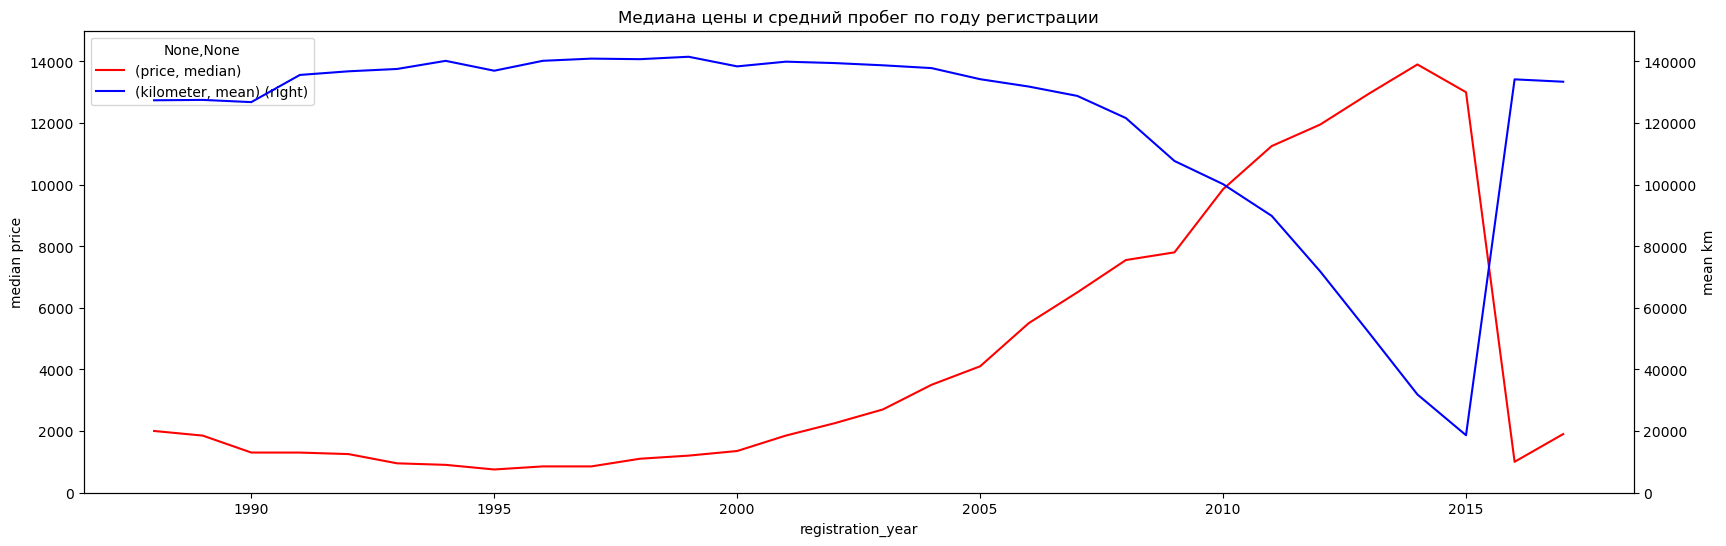

In [16]:
dfy=df[(1987<df.registration_year)&(df.registration_year<=2017)]
stat_years = dfy.groupby('registration_year')[['price','power','kilometer']].\
    agg([pd.Series.median,pd.Series.mean,pd.Series.count])
fig,ax=plt.subplots(figsize=(20,6))
ax.set_title('Медиана цены и средний пробег по году регистрации')
#figure.set_figsize((20,6))
stat_years.plot(y=('price','median'),color='r',ax=ax,ylabel='median price',ylim=(0,15_000))
stat_years.plot(y=('kilometer','mean'),color='b',ax=ax,ylabel='mean km',ylim=(0,150_000),secondary_y = True)
stat_years.tail()

price                     power                   \
                    median         mean count median       mean count   
registration_month                                                      
0                    750.0  1470.210986  2403   60.0  67.948398  2403   
1                   1000.0  2423.052083   384   75.0  74.856771   384   
2                   1000.0  2655.846369   358   75.0  78.734637   358   
3                   1200.0  3064.480801   599   75.0  80.313856   599   
4                   1000.0  2386.907348   626   75.0  84.017572   626   

                   kilometer                       
                      median           mean count  
registration_month                                 
0                   150000.0  136154.806492  2403  
1                   150000.0  129361.979167   384  
2                   150000.0  129022.346369   358  
3                   150000.0  125801.335559   599  
4                   150000.0  130351.437700   626

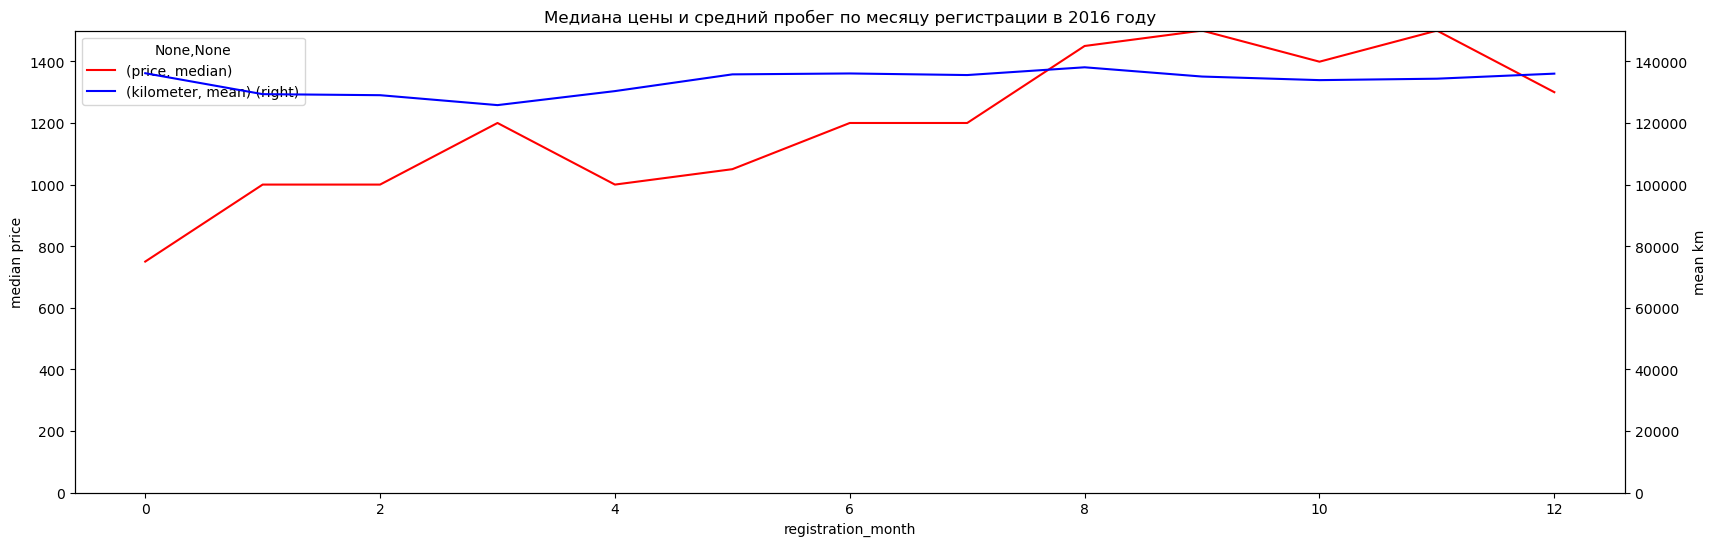

In [17]:
df16=df[df.registration_year==2016]
stat_months= df16.groupby('registration_month')[['price','power','kilometer']].\
    agg([pd.Series.median,pd.Series.mean,pd.Series.count])
fig,ax=plt.subplots(figsize=(20,6))
ax.set_title('Медиана цены и средний пробег по месяцу регистрации в 2016 году')
stat_months.plot(y=('price','median'),color='r',ax=ax,ylabel='median price',ylim=(0,1500))
stat_months.plot(y=('kilometer','mean'),color='b',ax=ax,ylabel='mean km',ylim=(0,150_000),secondary_y = True)
stat_months.head()

Сами данные по регистрации за 2016 однородны по месяцам и период январь- март не выделяется, здесь нет скачков по цене и пробегу(и пробег очень большой ) , так что я думаю что весь 2016 пришел из одного источника и относится к более старым машинам. <br>
Возможно это какие-то дубли, но я не нашел , с чем их соотнести    
Серьезные искажения по наиболее важным числовым признакам возраст/пробег для 2016 непонятно как исправлять <br>
поэтому я решил удалить их (2.5%) - это всё же лучше чем оставить <br>
С учетом нулевой цены , аномальных годов регистрации и 2016 года удалено  5.6% записей    

In [18]:
df = df[ (df.registration_year > 1920) & ((df.registration_year < 2016)) ]

#### Аномалии мощности

In [19]:
anomal_power_qty = ((df.power<30) | (df.power>1000)).sum()
print(f"Машин с нулевой или аномальной мощностью {anomal_power_qty} или {round(anomal_power_qty/df.shape[0]*100,1)}%")
df[(df.power<30) ].sort_values(by='power',ascending=False) 

Машин с нулевой или аномальной мощностью 29972 или 10.0%


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
353501,11300,sedan,1988,manual,29,other,150000,3,petrol,citroen,no,18347
133634,19800,small,1981,manual,29,other,5000,6,petrol,citroen,no,48308
122359,14800,convertible,1977,manual,29,other,90000,8,petrol,citroen,no,64395
246336,6500,bus,1960,manual,29,other,5000,7,petrol,fiat,yes,44581
312644,8700,convertible,1985,manual,29,other,90000,4,petrol,citroen,no,26131
...,...,...,...,...,...,...,...,...,...,...,...,...
115478,80,wagon,1995,manual,0,4_reihe,125000,0,petrol,peugeot,other,66131
115473,2299,sedan,1999,manual,0,golf,100000,5,petrol,volkswagen,no,52428
115465,899,small,1999,manual,0,lupo,150000,3,petrol,volkswagen,no,65232
115449,600,small,1998,manual,0,corsa,150000,10,petrol,opel,other,66620


Таких аномалий около 10 % процентов и внешне они выглядят как нормальные записи, так что их желательно сохранить<br>
Вместо нереальной мощности я можно  поставить медиану по модели и году<br>
Что касается того, что считать  аномалией, то вряд ли  есть массовые машины с мощностью ниже 10 л.с и выше 1000 л.с, 
но непонятно, где ставить отсечение  <br>
    Попробуем поймать по гистограмме переход "пуассоновского"(естественного)  в "равномерное" распределение (выбросы ожидаются более равномерно распределенными ) 


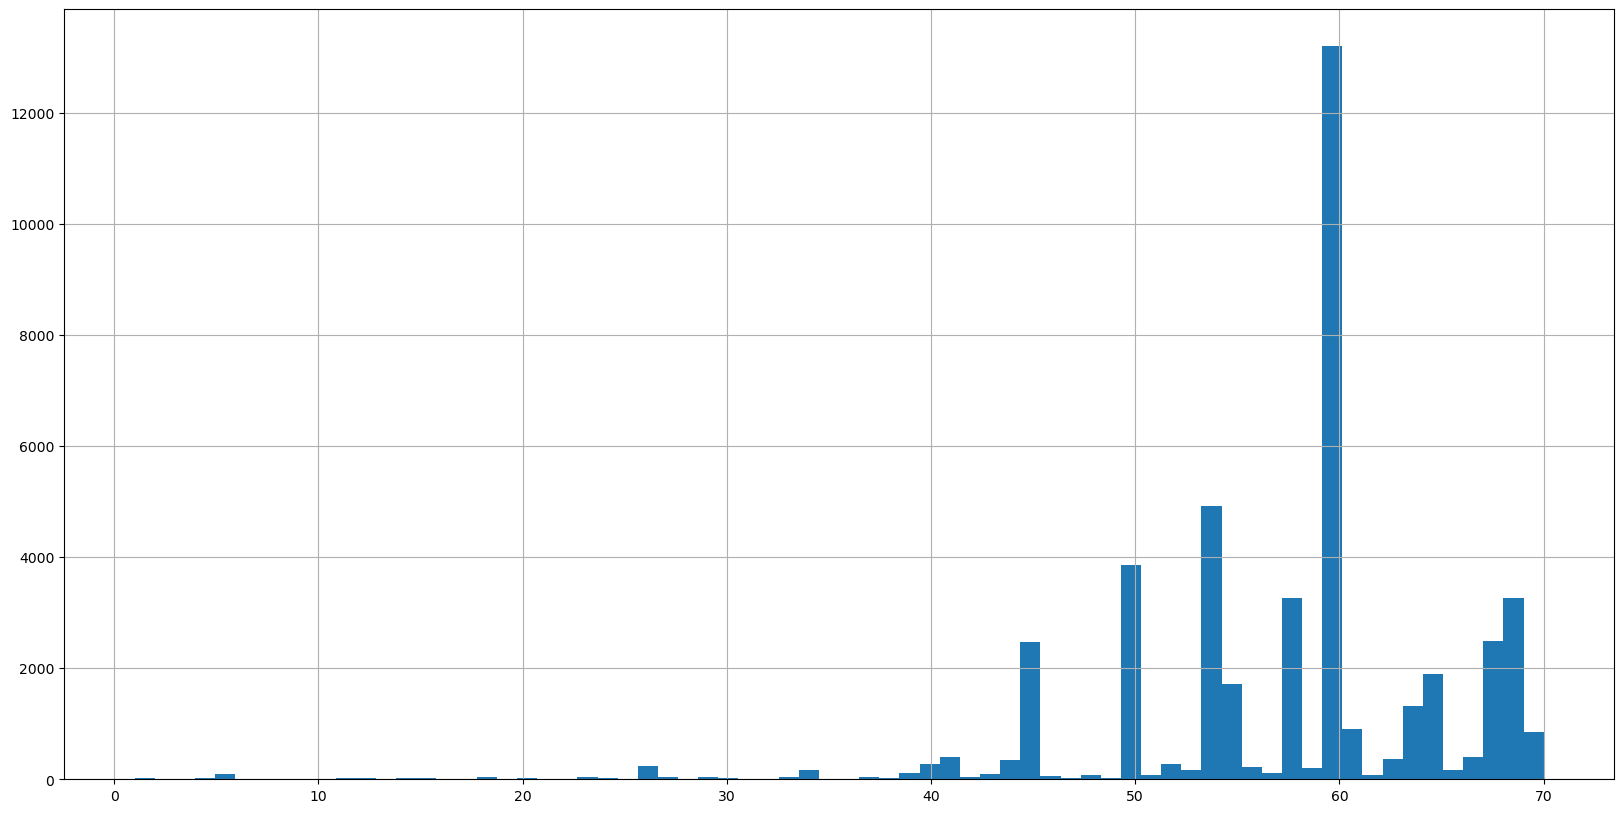

In [20]:
df[(df.power>0) & (df.power<=70)].power.hist(bins=70 , figsize=(20,10)) ;

Для слабых мощностей я предполагаю это ниже 20

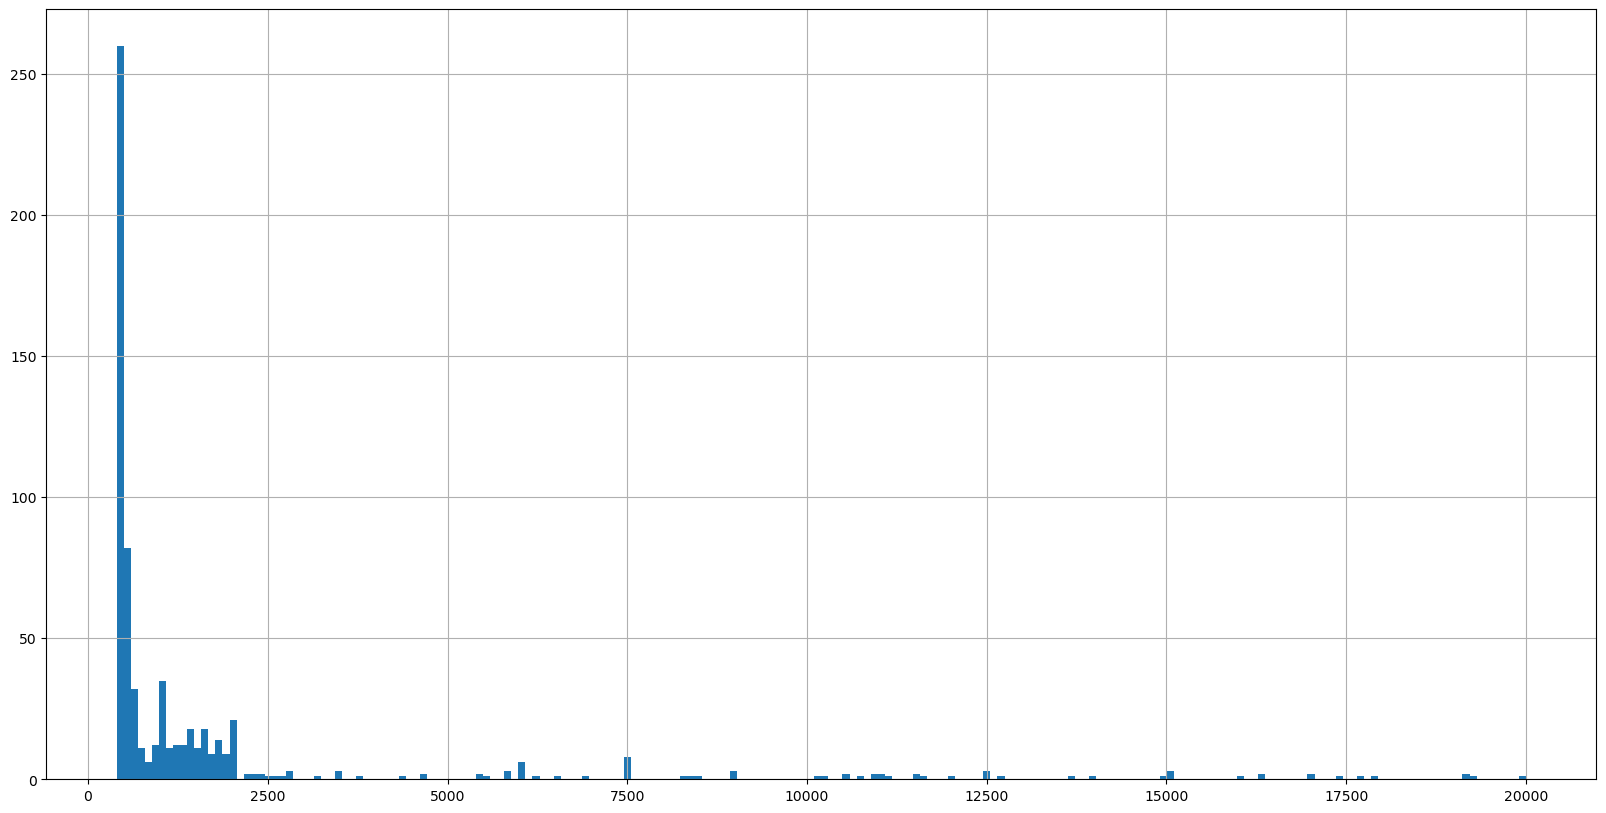

In [21]:
df[ (df.power>=400)].power.hist(bins=200 , figsize=(20,10)) ;

и для сильных выше 700 (на диаграмме шаг 100)

In [22]:
df[['model','registration_year','power']].head(60)

,model,registration_year,power
0,golf,1993,0
1,other,2011,190
2,grand,2004,163
3,golf,2001,75
4,fabia,2008,69
5,3er,1995,102
6,2_reihe,2004,109
8,c_max,2014,125
9,golf,1998,101
10,3_reihe,2004,105


Сбросим аномальные значения в 0 <br>
и заменим нули медианами


In [23]:
%%time
df.loc[(df.power<20) | (df.power>700),'power']=0
year_cols =['model','registration_year']
medians_by_year =  df.groupby(year_cols)['power'].agg(pd.Series.median)
medians_by_model =  df.groupby('model')['power'].agg(pd.Series.median)
median = df.power.median() 

def replace_zero_by_median(row):
    if row.power > 0:
        return (row.power)
    try:
        new_value =  medians_by_year[ tuple( row[year_cols] )]
        if new_value==0:
            new_value = medians_by_model[ row['model'] ]
        if new_value== 0:
            new_value= median
    except:
         new_value=1    
    return( new_value )    
    
df['power'] = df.apply(replace_zero_by_median,axis=1)
print(f" осталось {((df.power<20) | (df.power>700)).sum()} записей с аномальной мощностью")

 осталось 21 записей с аномальной мощностью
CPU times: total: 24 s
Wall time: 24.1 s


## Обучение моделей

Определим колонки признаков и цели 

In [24]:
cat_cols = [ c for c in df.columns if df.dtypes[c] == 'object'  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int64','float' ] ]
target='price'
features = [c for c in num_cols+cat_cols if c != 'price' ]
features

['registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_code',
 'vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'repaired']

и скопириуем в датафреймы  

In [25]:
for c in cat_cols:
    df[c] = df[c].astype('category')

X = df[features].copy()
y = df[target].copy()

Затем разделим на тренировочный и тестовый наборы с шаффлингом

In [26]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y,test_size = .25,shuffle=True)

Для исследования обучения и предсказания используется кроссвалидация по тренировочному набору  
Будут проверены все четыре алгоритма , используемые в LightGBM  
Так как их нужно запускать с немного разным набором параметров,
 решетка по каждому алгоримту считается отдельно   
В первую очередь я ищу оптимальное количество оценщиков и скорость обучения 

Для большинства тестов наблюдалось постепенное улучшение метрики при приемлимых временах обучения/предсказания, пока число оценшиков не превысило 500. Так как мне хотелось найти какой-то объективный экстремум, я прогонял тесты вплоть до n_estimators = 1024. При этом время обучения оставалось еще приемлимым, хотя вся поисковая решетка проходила тест больше чем за час.  
<font color="darkblue">Время выполнения оставшейся части блокнота составляет несколько часов</color>

Для ускорения расчет расчет проводится на субсэмплах   
Я считаю, что метрика получится несколько хуже, чем на полном наборе,  
но эта дополнительная ошибка буде более-менее равномерной для разных алгоритмов и гиперпараметров,  
так что можно будет выбрать лучший вариант и провести на нём финальное тестирование

### RandomForest   
Как я понимаю, это обычный RandomForest , без градиента  
Ячейка выполняется за ~30 минут

In [27]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['rf'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_rf = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_rf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_rf.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 3.57615e+06
[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1874.814, test=-1939.023) total time=   1.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[31]	valid_0's l2: 3.56342e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1879.760, test=-1911.329) total time=   1.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not 

[CV 1/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1861.343, test=-1924.571) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.53831e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 2/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1866.885, test=-1900.615) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52293e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.3, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1864.652, test=-1888.396) total time=  

[50]	valid_0's l2: 3.53831e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 2/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1866.885, test=-1900.615) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52293e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1864.652, test=-1888.396) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52733e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective

[50]	valid_0's l2: 3.52293e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1864.652, test=-1888.396) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52733e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1856.142, test=-1916.011) total time=   3.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.54929e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 1/4] END boosting=rf, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective

[50]	valid_0's l2: 3.52733e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1856.142, test=-1916.011) total time=   3.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.54929e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 1/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1861.343, test=-1924.571) total time=   3.3s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.53831e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 2/4] END boosting=rf, learning_rate=0.05, max_depth=32, n_estimators=256, num_leaves=511, object

[50]	valid_0's l2: 3.54929e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 1/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1861.343, test=-1924.571) total time=   3.5s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.53831e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 2/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1866.885, test=-1900.615) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52293e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, object

[50]	valid_0's l2: 3.53831e+06
Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 2/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1868.609, test=-1901.942) total time=   2.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52293e+06
Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1867.747, test=-1892.253) total time=   2.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.52733e+06
Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.02, max_depth=32, n_e

Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 3/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1876.403, test=-1899.994) total time=   1.2s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1868.949, test=-1928.517) total time=   1.6s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	valid_0's l2: 3.54929e+06
Did not meet early stopping. Best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 1/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, su

[50]	valid_0's l2: 3.52733e+06
Early stopping, best iteration is:
[83]	valid_0's l2: 3.4992e+06
[CV 4/4] END boosting=rf, learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1856.142, test=-1916.011) total time=   3.0s
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[50]	training's l2: 3.41019e+06
[100]	training's l2: 3.40023e+06
[150]	training's l2: 3.39076e+06
[200]	training's l2: 3.38727e+06
[250]	training's l2: 3.38488e+06
Did not meet early stopping. Best iteration is:
[256]	training's l2: 3.38461e+06
CPU times: total: 34min 54s
Wall time: 9min 12s


{'boosting': 'rf',
 'learning_rate': 0.3,
 'max_depth': 32,
 'n_estimators': 256,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Gradient Boosting Machine
Дефолтный алгоритм   
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [28]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['gbdt'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_def = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_def.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_def.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.43455e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1491.712, test=-1750.029) total time=   1.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.42101e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1493.292, test=-1730.393) total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 2.41962e+06
[CV 3/4] END boosting

[500]	valid_0's l2: 1.5628e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.5498e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-800.068, test=-2074.671) total time=  21.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.29864e+06
[100]	valid_0's l2: 2.10589e+06
[150]	valid_0's l2: 1.9711e+06
[200]	valid_0's l2: 1.87009e+06
[250]	valid_0's l2: 1.78831e+06
[300]	valid_0's l2: 1.72427e+06
[350]	valid_0's l2: 1.66826e+06
[400]	valid_0's l2: 1.62304e+06
[450]	valid_0's l2: 1.58326e+06
[500]	valid_0's l2: 1.55597e+06
Did not meet early stopping. Best iteration is:
[510]	valid_0's l2: 1.54624e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-807.520, test=-2056.376)

[CV 1/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1242.554, test=-1750.536) total time=   5.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.23086e+06
[100]	valid_0's l2: 2.00637e+06
Did not meet early stopping. Best iteration is:
[659]	valid_0's l2: 1.47597e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1245.131, test=-1732.377) total time=   5.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.2543e+06
[100]	valid_0's l2: 2.01567e+06
Did not meet early stopping. Best iteration is:
[659]	valid_0's l2: 1.47597e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511

[50]	valid_0's l2: 2.2543e+06
[100]	valid_0's l2: 2.01567e+06
[150]	valid_0's l2: 1.85256e+06
[200]	valid_0's l2: 1.73795e+06
[250]	valid_0's l2: 1.64563e+06
[300]	valid_0's l2: 1.57479e+06
[350]	valid_0's l2: 1.50985e+06
[400]	valid_0's l2: 1.4577e+06
[450]	valid_0's l2: 1.41274e+06
[500]	valid_0's l2: 1.38266e+06
[550]	valid_0's l2: 1.3462e+06
[600]	valid_0's l2: 1.31638e+06
[650]	valid_0's l2: 1.28921e+06
[700]	valid_0's l2: 1.2694e+06
[750]	valid_0's l2: 1.24671e+06
[800]	valid_0's l2: 1.22564e+06
[850]	valid_0's l2: 1.20758e+06
[900]	valid_0's l2: 1.19311e+06
[950]	valid_0's l2: 1.17882e+06
[1000]	valid_0's l2: 1.16606e+06
Did not meet early stopping. Best iteration is:
[1023]	valid_0's l2: 1.15585e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.2, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-571.469, test=-1915.899) total time=  46.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

[50]	valid_0's l2: 2.35379e+06
[100]	valid_0's l2: 2.08432e+06
[150]	valid_0's l2: 1.92285e+06
[200]	valid_0's l2: 1.79816e+06
[250]	valid_0's l2: 1.70463e+06
Did not meet early stopping. Best iteration is:
[1023]	valid_0's l2: 1.15585e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1167.508, test=-1640.578) total time=  10.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.35254e+06
[100]	valid_0's l2: 2.0975e+06
[150]	valid_0's l2: 1.93315e+06
[200]	valid_0's l2: 1.82049e+06
[250]	valid_0's l2: 1.72402e+06
Did not meet early stopping. Best iteration is:
[1023]	valid_0's l2: 1.15585e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.1, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1163.196, test=-1673.179) total time=  11.5s
[LightG

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1890.674, test=-1927.575) total time=   1.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1894.496, test=-1935.905) total time=   1.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_

[50]	valid_0's l2: 2.75347e+06
[100]	valid_0's l2: 2.29541e+06
[150]	valid_0's l2: 2.12699e+06
[200]	valid_0's l2: 2.01475e+06
[250]	valid_0's l2: 1.91854e+06
[300]	valid_0's l2: 1.8399e+06
[350]	valid_0's l2: 1.77037e+06
[400]	valid_0's l2: 1.71302e+06
[450]	valid_0's l2: 1.6589e+06
[500]	valid_0's l2: 1.61231e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 3/4] END boosting=gbdt, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1129.557, test=-1604.822) total time=  21.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 2.76003e+06
[100]	valid_0's l2: 2.30435e+06
[150]	valid_0's l2: 2.13521e+06
[200]	valid_0's l2: 2.01884e+06
[250]	valid_0's l2: 1.92433e+06
[300]	valid_0's l2: 1.84857e+06
[350]	valid_0's l2: 1.77988e+06
[400]	valid_0's l2: 1.72083e+06
[450]	valid_0's l2: 1.66524e+06
[50

[50]	valid_0's l2: 3.81788e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=64, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1758.403, test=-1847.822) total time=   2.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 3.82415e+06
[100]	valid_0's l2: 2.56589e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=128, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1513.887, test=-1652.252) total time=   4.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 3.81966e+06
[100]	valid_0's l2: 2.57071e+06
Did not meet early stopping. Best iteration is:
[1024]	val

[50]	valid_0's l2: 3.81966e+06
[100]	valid_0's l2: 2.57071e+06
[150]	valid_0's l2: 2.32353e+06
[200]	valid_0's l2: 2.1966e+06
[250]	valid_0's l2: 2.10428e+06
[300]	valid_0's l2: 2.02446e+06
[350]	valid_0's l2: 1.96186e+06
[400]	valid_0's l2: 1.90484e+06
[450]	valid_0's l2: 1.85374e+06
[500]	valid_0's l2: 1.80675e+06
[550]	valid_0's l2: 1.76627e+06
[600]	valid_0's l2: 1.72667e+06
[650]	valid_0's l2: 1.69161e+06
[700]	valid_0's l2: 1.65703e+06
[750]	valid_0's l2: 1.62499e+06
[800]	valid_0's l2: 1.59661e+06
[850]	valid_0's l2: 1.56895e+06
[900]	valid_0's l2: 1.54408e+06
[950]	valid_0's l2: 1.51973e+06
[1000]	valid_0's l2: 1.49625e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.03, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1055.561, test=-1613.132) total time=  47.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignor

[100]	valid_0's l2: 3.09052e+06
[150]	valid_0's l2: 2.55596e+06
[200]	valid_0's l2: 2.36912e+06
[250]	valid_0's l2: 2.25984e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1454.752, test=-1626.908) total time=   9.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 5.54664e+06
[100]	valid_0's l2: 3.08961e+06
[150]	valid_0's l2: 2.55517e+06
[200]	valid_0's l2: 2.36646e+06
[250]	valid_0's l2: 2.2579e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 2/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=256, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1457.351, test=-1618.171) total time=  11.0s
[LightGBM] [Warning] boosting is set

[200]	valid_0's l2: 2.3666e+06
[250]	valid_0's l2: 2.26005e+06
[300]	valid_0's l2: 2.18148e+06
[350]	valid_0's l2: 2.11641e+06
[400]	valid_0's l2: 2.05823e+06
[450]	valid_0's l2: 2.00665e+06
[500]	valid_0's l2: 1.96296e+06
[550]	valid_0's l2: 1.92083e+06
[600]	valid_0's l2: 1.88408e+06
[650]	valid_0's l2: 1.84946e+06
[700]	valid_0's l2: 1.81737e+06
[750]	valid_0's l2: 1.78817e+06
[800]	valid_0's l2: 1.75913e+06
[850]	valid_0's l2: 1.73229e+06
[900]	valid_0's l2: 1.70755e+06
[950]	valid_0's l2: 1.68337e+06
[1000]	valid_0's l2: 1.66115e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 4/4] END boosting=gbdt, learning_rate=0.02, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1156.486, test=-1609.699) total time=  47.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Did not meet early stopping. Best iteration is:
[1024]	valid_0

[50]	valid_0's l2: 9.85075e+06
[100]	valid_0's l2: 5.57772e+06
[150]	valid_0's l2: 3.83935e+06
[200]	valid_0's l2: 3.09098e+06
[250]	valid_0's l2: 2.73294e+06
[300]	valid_0's l2: 2.54349e+06
[350]	valid_0's l2: 2.43105e+06
[400]	valid_0's l2: 2.35162e+06
[450]	valid_0's l2: 2.29103e+06
[500]	valid_0's l2: 2.24026e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 1.12616e+06
[CV 1/4] END boosting=gbdt, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1448.576, test=-1619.603) total time=  19.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[50]	valid_0's l2: 9.84994e+06
[100]	valid_0's l2: 5.57643e+06
[150]	valid_0's l2: 3.83171e+06
[200]	valid_0's l2: 3.07915e+06
[250]	valid_0's l2: 2.72472e+06
[300]	valid_0's l2: 2.53728e+06
[350]	valid_0's l2: 2.42362e+06
[400]	valid_0's l2: 2.34652e+06
[450]	valid_0's l2: 2.28697e+06
[

{'boosting': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Gradient base one-sample
<font color="darkblue">Ячейка выполняется за ~90 минут </font>

In [29]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512,1024],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_goss= GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_goss.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_goss.best_params_

Fitting 4 folds for each of 42 candidates, totalling 168 fits
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 1.92358e+06
[CV 1/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1284.428, test=-1656.815) total time=   1.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 1.92358e+06
[CV 2/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1290.150, test=-1650.492) total time=   1.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[32]	valid_0's l2: 1.91387e+06
[CV 3/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=

[50]	valid_0's l2: 1.76253e+06
[100]	valid_0's l2: 1.51017e+06
[150]	valid_0's l2: 1.37754e+06
[200]	valid_0's l2: 1.28884e+06
[250]	valid_0's l2: 1.22812e+06
[300]	valid_0's l2: 1.18089e+06
[350]	valid_0's l2: 1.14433e+06
[400]	valid_0's l2: 1.11636e+06
[450]	valid_0's l2: 1.09453e+06
[500]	valid_0's l2: 1.0751e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's l2: 1.04465e+06
[CV 4/4] END boosting=goss, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-555.017, test=-1832.912) total time=  20.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.76908e+06
[100]	valid_0's l2: 1.51085e+06
[150]	valid_0's l2: 1.3774e+06
[200]	valid_0's l2: 1.28514e+06
[250]	valid_0's l2: 1.22435e+06
[300]	valid_0's l2: 1.17543e+06
[350]	valid_0's l2: 1.13784e+06
[400]	valid_0's l2: 1.10801e+06
[450]	valid_0's l2: 1.08227e+06
[500]	valid_0's l2: 1.06346e+06
Early st

[CV 4/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1020.019, test=-1664.546) total time=   8.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.82929e+06
[100]	valid_0's l2: 1.55845e+06
[150]	valid_0's l2: 1.40295e+06
[200]	valid_0's l2: 1.29948e+06
[250]	valid_0's l2: 1.22441e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 953752
[CV 1/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-823.842, test=-1683.139) total time=   9.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 1.82397e+06
[100]	valid_0's l2: 1.55993e+06
[150]	valid_0's l2: 1.40432e+06
[200]	valid_0's l2: 1.2975e+06
[250]	valid_0's l2: 1.22068e+06
Did not meet early stopping. Best iteration is:
[1024]

[650]	valid_0's l2: 983427
[700]	valid_0's l2: 969581
[750]	valid_0's l2: 958231
[800]	valid_0's l2: 946788
[850]	valid_0's l2: 937229
[900]	valid_0's l2: 928987
[950]	valid_0's l2: 922184
[1000]	valid_0's l2: 915260
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 4/4] END boosting=goss, learning_rate=0.2, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-411.682, test=-1772.028) total time=  45.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 1/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-1461.764, test=-1639.133) total time=   1.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[C

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 2/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-782.139, test=-1628.471) total time=  20.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.03266e+06
[100]	valid_0's l2: 1.74962e+06
[150]	valid_0's l2: 1.58543e+06
[200]	valid_0's l2: 1.46749e+06
[250]	valid_0's l2: 1.37869e+06
[300]	valid_0's l2: 1.30578e+06
[350]	valid_0's l2: 1.24677e+06
[400]	valid_0's l2: 1.1977e+06
[450]	valid_0's l2: 1.15645e+06
[500]	valid_0's l2: 1.12004e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 3/4] END boosting=goss, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-785.515, test=-1611.961) total time=  20.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current

[CV 4/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-1453.935, test=-1646.968) total time=   2.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.4783e+06
[100]	valid_0's l2: 2.02751e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 1/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1309.429, test=-1593.552) total time=   5.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.4715e+06
[100]	valid_0's l2: 2.01742e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 2/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-1308.789, test=-1582.970) total time=   5.7s

[900]	valid_0's l2: 1.12085e+06
[950]	valid_0's l2: 1.10234e+06
[1000]	valid_0's l2: 1.08495e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 2/4] END boosting=goss, learning_rate=0.05, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-762.244, test=-1601.770) total time=  43.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 2.476e+06
[100]	valid_0's l2: 2.01467e+06
[150]	valid_0's l2: 1.83959e+06
[200]	valid_0's l2: 1.72064e+06
[250]	valid_0's l2: 1.62707e+06
[300]	valid_0's l2: 1.55056e+06
[350]	valid_0's l2: 1.48467e+06
[400]	valid_0's l2: 1.42888e+06
[450]	valid_0's l2: 1.37991e+06
[500]	valid_0's l2: 1.33649e+06
[550]	valid_0's l2: 1.2982e+06
[600]	valid_0's l2: 1.26431e+06
[650]	valid_0's l2: 1.23324e+06
[700]	valid_0's l2: 1.20498e+06
[750]	valid_0's l2: 1.17884e+06
[800]	valid_0's l2: 1.1547e+06
[850]	valid_0's l2: 1.13359e+06
[900]	vali

[250]	valid_0's l2: 1.82523e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 3/4] END boosting=goss, learning_rate=0.03, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1267.085, test=-1563.168) total time=  10.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 3.54534e+06
[100]	valid_0's l2: 2.30575e+06
[150]	valid_0's l2: 2.06601e+06
[200]	valid_0's l2: 1.93827e+06
[250]	valid_0's l2: 1.84417e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 4/4] END boosting=goss, learning_rate=0.03, max_depth=32, n_estimators=256, num_leaves=511, objective=l2;, score=(train=-1262.612, test=-1597.773) total time=  10.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 3.54002e+06
[100]	valid_0's l2: 2.30401e+06
[150]	valid_0's l2: 2.0642e+06
[200]	v

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-2820.448, test=-2848.336) total time=   1.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=32, num_leaves=511, objective=l2;, score=(train=-2814.684, test=-2861.965) total time=   1.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.31731e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=64, num_leaves=511, objective=l2;, score=(train=-2015.355, test=-2089.699) total time=   2.8s
[LightGBM] [Warnin

[400]	valid_0's l2: 1.81153e+06
[450]	valid_0's l2: 1.76146e+06
[500]	valid_0's l2: 1.71683e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1196.829, test=-1590.429) total time=  21.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 5.31731e+06
[100]	valid_0's l2: 2.81663e+06
[150]	valid_0's l2: 2.30285e+06
[200]	valid_0's l2: 2.11739e+06
[250]	valid_0's l2: 2.00917e+06
[300]	valid_0's l2: 1.92951e+06
[350]	valid_0's l2: 1.86332e+06
[400]	valid_0's l2: 1.80746e+06
[450]	valid_0's l2: 1.75764e+06
[500]	valid_0's l2: 1.71308e+06
[550]	valid_0's l2: 1.6735e+06
[600]	valid_0's l2: 1.63668e+06
[650]	valid_0's l2: 1.60284e+06
[700]	valid_0's l2: 1.57167e+06
[750]	valid_0's l2: 1.54227e+06
[800]	valid_0's l2: 1.51468e+06
[850]	valid_0's l2: 1.48917e+06
[900]	va

[50]	valid_0's l2: 9.65376e+06
[100]	valid_0's l2: 5.35577e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 3/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-2026.009, test=-2084.863) total time=   6.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.6458e+06
[100]	valid_0's l2: 5.34549e+06
Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 4/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=128, num_leaves=511, objective=l2;, score=(train=-2017.444, test=-2104.859) total time=   5.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.64582e+06
[100]	valid_0's l2: 5.34437e+06
[150]	valid_0's l2: 3.56954e+06
[200]	valid_0's l2: 2.82457e+06
[250]	valid_0's l2: 2.483e+06
Did not me

Did not meet early stopping. Best iteration is:
[1024]	valid_0's l2: 886092
[CV 3/4] END boosting=goss, learning_rate=0.01, max_depth=32, n_estimators=1024, num_leaves=511, objective=l2;, score=(train=-1200.716, test=-1556.757) total time=  44.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's l2: 9.6458e+06
[100]	valid_0's l2: 5.34549e+06
[150]	valid_0's l2: 3.56878e+06
[200]	valid_0's l2: 2.82489e+06
[250]	valid_0's l2: 2.48385e+06
[300]	valid_0's l2: 2.30377e+06
[350]	valid_0's l2: 2.19402e+06
[400]	valid_0's l2: 2.11855e+06
[450]	valid_0's l2: 2.05983e+06
[500]	valid_0's l2: 2.01008e+06
[550]	valid_0's l2: 1.9671e+06
[600]	valid_0's l2: 1.92917e+06
[650]	valid_0's l2: 1.89517e+06
[700]	valid_0's l2: 1.86399e+06
[750]	valid_0's l2: 1.83554e+06
[800]	valid_0's l2: 1.80836e+06
[850]	valid_0's l2: 1.78282e+06
[900]	valid_0's l2: 1.75864e+06
[950]	valid_0's l2: 1.73518e+06
[1000]	valid_0's l2: 1.71349e+06
Did not

{'boosting': 'goss',
 'learning_rate': 0.01,
 'max_depth': 32,
 'n_estimators': 1024,
 'num_leaves': 511,
 'objective': 'l2'}

### Dart
<font color="darkblue">Ячейка выполняется за ~150 минут </font>   
Исключил из теста n_estimators = 1024 , так как при этом тест идет слишком долго

In [30]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['dart'],
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.3, .2,.1,.05,.03,.02,.01],
    'n_estimators': [32,64,128,256,512],
    'max_depth':  [32],
    'num_leaves': [511]       
}

gbm_dart = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3, 
                   scoring='neg_root_mean_squared_error' ) 
gbm_dart.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['l2'],callbacks=cbf)

gbm_dart.best_params_

Fitting 4 folds for each of 35 candidates, totalling 140 fits
[CV 1/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1495.615, test=-1723.371) total time=   1.6s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1496.537, test=-1709.176) total time=   1.8s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1503.472, test=-1704.021) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 4/4]

[500]	valid_0's l2: 1.53996e+06
[CV 4/4] END boosting=dart, learning_rate=0.3, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1018.902, test=-1736.669) total time= 2.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1515.111, test=-1684.521) total time=   1.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1519.202, test=-1663.733) total time=   1.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 3/4] END boosting=dart, learning_

[50]	valid_0's l2: 2.49344e+06
[100]	valid_0's l2: 2.22317e+06
[150]	valid_0's l2: 2.10556e+06
[200]	valid_0's l2: 1.96386e+06
[250]	valid_0's l2: 1.88107e+06
[300]	valid_0's l2: 1.79905e+06
[350]	valid_0's l2: 1.74457e+06
[400]	valid_0's l2: 1.68515e+06
[450]	valid_0's l2: 1.62496e+06
[500]	valid_0's l2: 1.58484e+06
[CV 4/4] END boosting=dart, learning_rate=0.2, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1077.814, test=-1675.400) total time= 2.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1648.513, test=-1747.612) total time=   1.4s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.1, max_depth=32,

[50]	valid_0's l2: 2.99409e+06
[100]	valid_0's l2: 2.81465e+06
[150]	valid_0's l2: 2.58467e+06
[200]	valid_0's l2: 2.26755e+06
[250]	valid_0's l2: 2.14289e+06
[300]	valid_0's l2: 2.05031e+06
[350]	valid_0's l2: 1.99046e+06
[400]	valid_0's l2: 1.89442e+06
[450]	valid_0's l2: 1.82009e+06
[500]	valid_0's l2: 1.78026e+06
[CV 4/4] END boosting=dart, learning_rate=0.1, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1215.968, test=-1620.981) total time= 2.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=32, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2103.549, test=-2152.592) total time=   1.9s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 2/4] END boosting=dart, learning_rate=0.05, max_depth=3

[CV 3/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1370.061, test=-1594.381) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 4.40406e+06
[100]	valid_0's l2: 4.40755e+06
[150]	valid_0's l2: 3.90291e+06
[200]	valid_0's l2: 3.03468e+06
[250]	valid_0's l2: 2.69403e+06
[300]	valid_0's l2: 2.47412e+06
[350]	valid_0's l2: 2.40895e+06
[400]	valid_0's l2: 2.20898e+06
[450]	valid_0's l2: 2.12372e+06
[500]	valid_0's l2: 2.07684e+06
[CV 4/4] END boosting=dart, learning_rate=0.05, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1363.079, test=-1626.368) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV 1/4] END boosting=dart, learning_rate=0.03, max_depth

[50]	valid_0's l2: 6.62391e+06
[100]	valid_0's l2: 6.67753e+06
[150]	valid_0's l2: 6.01419e+06
[200]	valid_0's l2: 4.48643e+06
[250]	valid_0's l2: 3.71491e+06
[300]	valid_0's l2: 3.17166e+06
[350]	valid_0's l2: 3.04999e+06
[400]	valid_0's l2: 2.62206e+06
[450]	valid_0's l2: 2.45998e+06
[500]	valid_0's l2: 2.39018e+06
[CV 3/4] END boosting=dart, learning_rate=0.03, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1496.682, test=-1640.111) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 6.61595e+06
[100]	valid_0's l2: 6.67911e+06
[150]	valid_0's l2: 6.01773e+06
[200]	valid_0's l2: 4.48945e+06
[250]	valid_0's l2: 3.73005e+06
[300]	valid_0's l2: 3.18992e+06
[350]	valid_0's l2: 3.05972e+06
[400]	valid_0's l2: 2.63087e+06
[450]	valid_0's l2: 2.46554e+06
[500]	valid_0's l2: 2.39955e+06
[CV 4/4] END boosting=dart, learning_rate=0.03, ma

[CV 2/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1646.003, test=-1743.259) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 9.00319e+06
[100]	valid_0's l2: 9.18427e+06
[150]	valid_0's l2: 8.57875e+06
[200]	valid_0's l2: 6.63159e+06
[250]	valid_0's l2: 5.3943e+06
[300]	valid_0's l2: 4.38655e+06
[350]	valid_0's l2: 4.11245e+06
[400]	valid_0's l2: 3.34295e+06
[450]	valid_0's l2: 3.00436e+06
[500]	valid_0's l2: 2.86037e+06
[CV 3/4] END boosting=dart, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-1645.459, test=-1741.858) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 8.98706e+06
[100]	valid_0's l2: 9.18913

[100]	valid_0's l2: 1.41102e+07
[150]	valid_0's l2: 1.41579e+07
[200]	valid_0's l2: 1.22141e+07
[250]	valid_0's l2: 1.05356e+07
[300]	valid_0's l2: 8.72608e+06
[350]	valid_0's l2: 8.05438e+06
[400]	valid_0's l2: 6.45156e+06
[450]	valid_0's l2: 5.50265e+06
[500]	valid_0's l2: 5.00266e+06
[CV 2/4] END boosting=dart, learning_rate=0.01, max_depth=32, n_estimators=512, num_leaves=511, objective=l2, subsample=0.25, subsample_freq=4;, score=(train=-2182.282, test=-2214.118) total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[50]	valid_0's l2: 1.32365e+07
[100]	valid_0's l2: 1.41255e+07
[150]	valid_0's l2: 1.41751e+07
[200]	valid_0's l2: 1.22327e+07
[250]	valid_0's l2: 1.05487e+07
[300]	valid_0's l2: 8.73961e+06
[350]	valid_0's l2: 8.06958e+06
[400]	valid_0's l2: 6.46059e+06
[450]	valid_0's l2: 5.51111e+06
[500]	valid_0's l2: 5.0037e+06
[CV 3/4] END boosting=dart, learning_rate=0.01, max_depth=32, n_estimators=512, nu

{'boosting': 'dart',
 'learning_rate': 0.1,
 'max_depth': 32,
 'n_estimators': 512,
 'num_leaves': 511,
 'objective': 'l2',
 'subsample': 0.25,
 'subsample_freq': 4}

### Тест глубины дерева
Тест для оценки влияния параметров глубины дерева и количества листьев, которые должны проверяться совместно
<font color="darkblue">Ячейка выполняется за ~75 минут </font>

In [31]:
%%time

cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
estimator = lgb.LGBMRegressor( )

warnings.filterwarnings('ignore')
param_grid = {
    'boosting' :['goss'],
#     'subsample':[.25],
#     'subsample_freq':[4],
    'objective':['l2'],
    'learning_rate': [.02],
    'n_estimators': [512],
    'max_depth':  [16,32,64,128,256],
    'num_leaves': [255,511,1023,2047]       
}

gbm_tree = GridSearchCV(estimator, param_grid, cv=4, return_train_score=True, verbose=3,
                          scoring='neg_root_mean_squared_error' )
gbm_tree.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Training until validation scores don't improve for 5 rounds
[50]	valid_0's rmse: 2351.19	valid_0's l2: 5.52808e+06
[100]	valid_0's rmse: 1740.38	valid_0's l2: 3.02892e+06
[150]	valid_0's rmse: 1582.25	valid_0's l2: 2.50352e+06
[200]	valid_0's rmse: 1524.75	valid_0's l2: 2.32487e+06
[250]	valid_0's rmse: 1492.37	valid_0's l2: 2.22716e+06
[300]	valid_0's rmse: 1470.09	valid_0's l2: 2.16116e+06
[350]	valid_0's rmse: 1452.01	valid_0's l2: 2.10832e+06
[400]	valid_0's rmse: 1435.94	valid_0's l2: 2.06191e+06
[450]	valid_0's rmse: 1421.76	valid_0's l2: 2.02141e+06
[500]	valid_0's rmse: 1408.82	valid_0's l2: 1.98477e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1405.71	valid_0's l2: 1.97603e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1339.429, test=-1588.048) total time=  14.8s
[LightGBM] [Warning] boosting is set=goss, boo

[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=16, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1151.965, test=-1582.222) total time=  27.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2267.43	valid_0's l2: 5.14122e+06
[100]	valid_0's rmse: 1623.24	valid_0's l2: 2.6349e+06
[150]	valid_0's rmse: 1459.12	valid_0's l2: 2.12902e+06
[200]	valid_0's rmse: 1396.09	valid_0's l2: 1.94908e+06
[250]	valid_0's rmse: 1363.21	valid_0's l2: 1.85835e+06
[300]	valid_0's rmse: 1340.3	valid_0's l2: 1.7964e+06
[350]	valid_0's rmse: 1321.54	valid_0's l2: 1.74646e+06
[400]	valid_0's rmse: 1305.17	valid_0's l2: 1.70347e+06
[450]	valid_0's rmse: 1290.71	valid_0's l2: 1.66593e+06
[500]	valid_0's rmse: 1276.71	valid_0's l2: 1.62999e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1273.23	valid_0's l2: 1.62113e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=16,

[450]	valid_0's rmse: 1412.88	valid_0's l2: 1.99622e+06
[500]	valid_0's rmse: 1399.41	valid_0's l2: 1.95835e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1243.3	valid_0's l2: 1.5458e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1331.339, test=-1575.515) total time=  15.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2351.68	valid_0's l2: 5.53039e+06
[100]	valid_0's rmse: 1739.99	valid_0's l2: 3.02758e+06
[150]	valid_0's rmse: 1580.9	valid_0's l2: 2.49926e+06
[200]	valid_0's rmse: 1522.08	valid_0's l2: 2.31674e+06
[250]	valid_0's rmse: 1489.12	valid_0's l2: 2.21748e+06
[300]	valid_0's rmse: 1464.47	valid_0's l2: 2.14468e+06
[350]	valid_0's rmse: 1444.89	valid_0's l2: 2.08772e+06
[400]	valid_0's rmse: 1427.94	valid_0's l2: 2.03901e+06
[450]	valid_0's rmse: 1412.36	valid_0's l2: 1.99476e+06
[500]	

[250]	valid_0's rmse: 1339.17	valid_0's l2: 1.79337e+06
[300]	valid_0's rmse: 1304.32	valid_0's l2: 1.70125e+06
[350]	valid_0's rmse: 1275.09	valid_0's l2: 1.62586e+06
[400]	valid_0's rmse: 1250.07	valid_0's l2: 1.56267e+06
[450]	valid_0's rmse: 1227.49	valid_0's l2: 1.50672e+06
[500]	valid_0's rmse: 1207.19	valid_0's l2: 1.4573e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1202.6	valid_0's l2: 1.44625e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=32, n_estimators=512, num_leaves=1023, objective=l2;, score=(train=-1055.816, test=-1562.288) total time=  32.1s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2269.33	valid_0's l2: 5.14985e+06
[100]	valid_0's rmse: 1623.94	valid_0's l2: 2.63717e+06
[150]	valid_0's rmse: 1457.54	valid_0's l2: 2.12442e+06
[200]	valid_0's rmse: 1389.12	valid_0's l2: 1.92965e+06
[250]	valid_0's rmse: 1345.09	valid_0's l2: 1.80926e+06
[300

[50]	valid_0's rmse: 2352.02	valid_0's l2: 5.53201e+06
[100]	valid_0's rmse: 1741.24	valid_0's l2: 3.03193e+06
[150]	valid_0's rmse: 1582.15	valid_0's l2: 2.50319e+06
[200]	valid_0's rmse: 1524.2	valid_0's l2: 2.3232e+06
[250]	valid_0's rmse: 1491.63	valid_0's l2: 2.22496e+06
[300]	valid_0's rmse: 1468.22	valid_0's l2: 2.15566e+06
[350]	valid_0's rmse: 1448.63	valid_0's l2: 2.09852e+06
[400]	valid_0's rmse: 1431.83	valid_0's l2: 2.05013e+06
[450]	valid_0's rmse: 1417.32	valid_0's l2: 2.00879e+06
[500]	valid_0's rmse: 1403.4	valid_0's l2: 1.96953e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1137.9	valid_0's l2: 1.29482e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=255, objective=l2;, score=(train=-1327.015, test=-1599.630) total time=  14.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2305.93	valid_0's l2: 5.31731e+06
[100]	va

[50]	valid_0's rmse: 2237.12	valid_0's l2: 5.00473e+06
[100]	valid_0's rmse: 1585.67	valid_0's l2: 2.51436e+06
[150]	valid_0's rmse: 1415.45	valid_0's l2: 2.00351e+06
[200]	valid_0's rmse: 1342.11	valid_0's l2: 1.80127e+06
[250]	valid_0's rmse: 1293.5	valid_0's l2: 1.67313e+06
[300]	valid_0's rmse: 1254.79	valid_0's l2: 1.57449e+06
[350]	valid_0's rmse: 1222.1	valid_0's l2: 1.49354e+06
[400]	valid_0's rmse: 1193.74	valid_0's l2: 1.42501e+06
[450]	valid_0's rmse: 1168.69	valid_0's l2: 1.36585e+06
[500]	valid_0's rmse: 1146.37	valid_0's l2: 1.31416e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1137.9	valid_0's l2: 1.29482e+06
[CV 1/4] END boosting=goss, learning_rate=0.02, max_depth=64, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-946.684, test=-1587.990) total time=  50.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2235.84	valid_0's l2: 4.99898e+06
[100]	v

[50]	valid_0's rmse: 2305.5	valid_0's l2: 5.31534e+06
[100]	valid_0's rmse: 1677.59	valid_0's l2: 2.8143e+06
[150]	valid_0's rmse: 1516.6	valid_0's l2: 2.30008e+06
[200]	valid_0's rmse: 1455.14	valid_0's l2: 2.11744e+06
[250]	valid_0's rmse: 1417.39	valid_0's l2: 2.009e+06
[300]	valid_0's rmse: 1388.86	valid_0's l2: 1.92894e+06
[350]	valid_0's rmse: 1365.16	valid_0's l2: 1.86365e+06
[400]	valid_0's rmse: 1344.08	valid_0's l2: 1.80655e+06
[450]	valid_0's rmse: 1325.4	valid_0's l2: 1.75669e+06
[500]	valid_0's rmse: 1308.5	valid_0's l2: 1.71217e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1134.93	valid_0's l2: 1.28806e+06
[CV 2/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1201.243, test=-1574.609) total time=  20.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2308.22	valid_0's l2: 5.32789e+06
[100]	vali

[50]	valid_0's rmse: 2236.95	valid_0's l2: 5.00395e+06
[100]	valid_0's rmse: 1583.86	valid_0's l2: 2.5086e+06
[150]	valid_0's rmse: 1411.86	valid_0's l2: 1.99334e+06
[200]	valid_0's rmse: 1338.18	valid_0's l2: 1.79072e+06
[250]	valid_0's rmse: 1289.1	valid_0's l2: 1.66178e+06
[300]	valid_0's rmse: 1249.76	valid_0's l2: 1.56191e+06
[350]	valid_0's rmse: 1216.71	valid_0's l2: 1.48038e+06
[400]	valid_0's rmse: 1188	valid_0's l2: 1.41135e+06
[450]	valid_0's rmse: 1162.65	valid_0's l2: 1.35175e+06
[500]	valid_0's rmse: 1140	valid_0's l2: 1.29959e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1134.93	valid_0's l2: 1.28806e+06
[CV 3/4] END boosting=goss, learning_rate=0.02, max_depth=128, n_estimators=512, num_leaves=2047, objective=l2;, score=(train=-947.872, test=-1567.428) total time=  49.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2238.59	valid_0's l2: 5.01129e+06
[100]	valid

[50]	valid_0's rmse: 2306.38	valid_0's l2: 5.31939e+06
[100]	valid_0's rmse: 1679.49	valid_0's l2: 2.82067e+06
[150]	valid_0's rmse: 1518.1	valid_0's l2: 2.30462e+06
[200]	valid_0's rmse: 1456.45	valid_0's l2: 2.12126e+06
[250]	valid_0's rmse: 1419.16	valid_0's l2: 2.01401e+06
[300]	valid_0's rmse: 1390.69	valid_0's l2: 1.93402e+06
[350]	valid_0's rmse: 1367.02	valid_0's l2: 1.86875e+06
[400]	valid_0's rmse: 1346.22	valid_0's l2: 1.81232e+06
[450]	valid_0's rmse: 1327.78	valid_0's l2: 1.76301e+06
[500]	valid_0's rmse: 1310.89	valid_0's l2: 1.71843e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1134.93	valid_0's l2: 1.28806e+06
[CV 4/4] END boosting=goss, learning_rate=0.02, max_depth=256, n_estimators=512, num_leaves=511, objective=l2;, score=(train=-1197.866, test=-1590.871) total time=  20.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[50]	valid_0's rmse: 2267.48	valid_0's l2: 5.14148e+06
[100

[50]	training's rmse: 2296.37	training's l2: 5.27333e+06
[100]	training's rmse: 1659.66	training's l2: 2.75446e+06
[150]	training's rmse: 1490.42	training's l2: 2.22135e+06
[200]	training's rmse: 1420.9	training's l2: 2.01897e+06
[250]	training's rmse: 1377.89	training's l2: 1.89859e+06
[300]	training's rmse: 1343.95	training's l2: 1.8062e+06
[350]	training's rmse: 1315.21	training's l2: 1.72978e+06
[400]	training's rmse: 1289.81	training's l2: 1.66362e+06
[450]	training's rmse: 1266.94	training's l2: 1.60515e+06
[500]	training's rmse: 1246.03	training's l2: 1.55259e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1134.93	valid_0's l2: 1.28806e+06
CPU times: total: 3h 21min 52s
Wall time: 53min 20s


GridSearchCV(cv=4, estimator=LGBMRegressor(),
             param_grid={'boosting': ['goss'], 'learning_rate': [0.02],
                         'max_depth': [16, 32, 64, 128, 256],
                         'n_estimators': [512],
                         'num_leaves': [255, 511, 1023, 2047],
                         'objective': ['l2']},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=3)

## Анализ моделей

### Класс и функция для  оценивающих графиков   
Результаты теста иллюстрированы двумя графиками, показывающими 
* метрику RMSE и
* время 1.обучения 2.предсказания 
для различных оценщиков и скоростей обучения. Точки, соответствующие одной скорости соединенины линией одного цвета
Для удобства сравнения все графики приведены к одному интервалу и масштабу

In [32]:
class LGDMPlot:
    def __init__(self,gbm,ax,x,y,along,through):
        self.res= gbm.cv_results_
        self.x = x                   # name of scores mean  along X axes , typically time
        self.y = y                   # name of scores mean  along Y axes, typically RMSE  
        self.along = along           # name of parameter promoting along a line, typically n_estimators
        self.through = through       # name of parameter matching one line and promoting across lines,typically learning r
        self.rf = self.create_dataframe()
        self.scale = 4
        self.point_scale = 6
        self.marker='D'
        self.ax = ax
        self.point_size = lambda i,min_size: (np.log2(i)-np.log2(min_size)) * self.point_scale
# point size illustrates amount of estimators        
        self.alpha = lambda i,th_size: .2+(i/th_size)*(1-.25)
# there "alpha" of a line  must hint best results, mathching rank  "i" of best score on the  line
# unfortunately there is a bug and I hasn't found time to fix it yet   
        self.limits = { 'test_score': (1600,2400),'train_score': (1400,1800), 'fit_time':(0,50), 'score_time':(0,15)  }
#  intervals to catch best socres, the same for all tests     
        self.title = f"Dependency of {self.x} and {self.y}  on {self.through } and {self.along}"

    def set_ranks_through(self):
        ranks = self.rf.groupby(self.through)[self.y].max().rank()
        self.rf['rank_through'] = self.rf[self.through].apply(lambda i:ranks[i])        
        
    def create_dataframe(self):
        params = ['n_estimators','learning_rate','max_depth','num_leaves','boosting']
        means = ['fit_time','score_time','train_score','test_score']
        res_cols = list( map( lambda s: 'param_'+s, params))+list( map( lambda s: 'mean_'+s, means) ) 
        f = pd.DataFrame( {k:self.res[k] for k in res_cols} )
        f.columns = params+means  
        f['train_score'] = -f.train_score
        f['test_score'] = -f.test_score
        return f 
    
   # method to pick data for lines  
    def create_batches(self):
        self.set_ranks_through()
       
        batches = []
        th_values = list(sorted(set(self.rf[self.through])))
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['r','y','g','b','k'], len(th_values))          
        for i in range(len(th_values)):
            val = th_values[i]
            dat = self.rf[self.rf[self.through] ==val ].sort_values(by=self.along)
            dat['s'] = dat[self.along].apply(self.point_size,min_size=dat[self.along].min()-1 )

            batches.append( {'x':dat[self.x],'y':dat[self.y],
                             'c':self.color(i),'z':dat[self.along], 
                             's':dat['s'], 'a': self.alpha(dat.rank_through.iloc[1],len(th_values)),
                             'l':val , 'm': dat[self.along] }  )
            self.size_labels = dat[self.along]
        return(batches)    
        
    def draw(self):
        self.init_plot()
        batches = self.create_batches()
        self.color =  plc.LinearSegmentedColormap.from_list(' ', ['b','r'], len(batches)) 
        for b in batches:
            self.scatter = self.draw_points(b)
            self.line = self.draw_line(b)
        self.draw_legends()
    
    def init_plot(self):
        self.ax.set_title(self.title)
        self.ax.set_xlabel(self.x)
        plt.ylabel(self.y)
        if self.y in self.limits:
            self.ax.set_ylim( self.limits[self.y])
        if self.x in self.limits:
            self.ax.set_xlim( self.limits[self.x])
        
    # draw point as scattered plot 
    def draw_points(self,b):
        return( self.ax.scatter(b['x'],b['y'],color=b['c'],marker=self.marker,s=b['s']) )

    # connect points of the same learning rate for better readability 
    def draw_line(self,b):
        return( self.ax.plot(b['x'],b['y'],color=b['c'],label=b['l'] ,alpha= b['a']) )
    
    def draw_legends(self):
        legend_lines = self.ax.legend(loc='upper right', title = self.through)
        self.ax.add_artist(legend_lines)
        handles,labels = self.scatter.legend_elements(prop='sizes')
        sl = list(self.size_labels.astype(str).values)
        self.ax.legend(handles=handles,labels=sl,loc='upper center',title=self.along)


In [33]:
# function to draw a pair of plots for fit/prediction time 
def lgbm_figure(gbm,xs,ys,along,through,figsize=(20,8)):
    fig,axs = plt.subplots(ncols=len(xs), nrows=len(ys), figsize=figsize )  
    for j in range(len(ys)):
        for i in range(len(xs)):
            if (len(xs)==1) & (len(ys)==1):
                ax = axs
            elif  (len(xs)==1) | (len(ys)==1):
                ax = axs[(j+1)*(i+1)-1]
            else:   
                ax = axs[j,i] 
            LGDMPlot(gbm,ax,xs[i],ys[j],along=along,through=through).draw()

### Оценка результатов

В задании мало  сведений о бизнес- процессе, чтобы сделать определённые  предположения о допустимой ошибки и временах предсказаний.  
Я прдполагаю, что цену имеет смысл предсказывать с точность до 100 - примерно так округляются цены продаж и большая тчность будет размыта ошибками из-за такого округления  
Время обучения меньше 8 часов считаю некритичным, так преппологаю, что модель будет переобучаться ночью и оставаться неизменной в течение дня. Скорее время обучения критично для тестов. Конечно , в дальнейшем база данных может быть существенно расширена и требуется как-то оценивать масштабируемость, но пока данных для такой оценки я не вижу. В любом случая, при скоростях обучения в десятки минут здесь остается существенный запас
Предвполагаю что время предсказания больше нескольких секунд уже будет оказывать влияние на бизнес, так как потенциальные клиенты хотят "мгновенные" ответы. Уменьшать это время дальше вряд ли имеет смысл, если только многократное пресказание не используется в каких-то расчетах.  

### Default gradient boosting

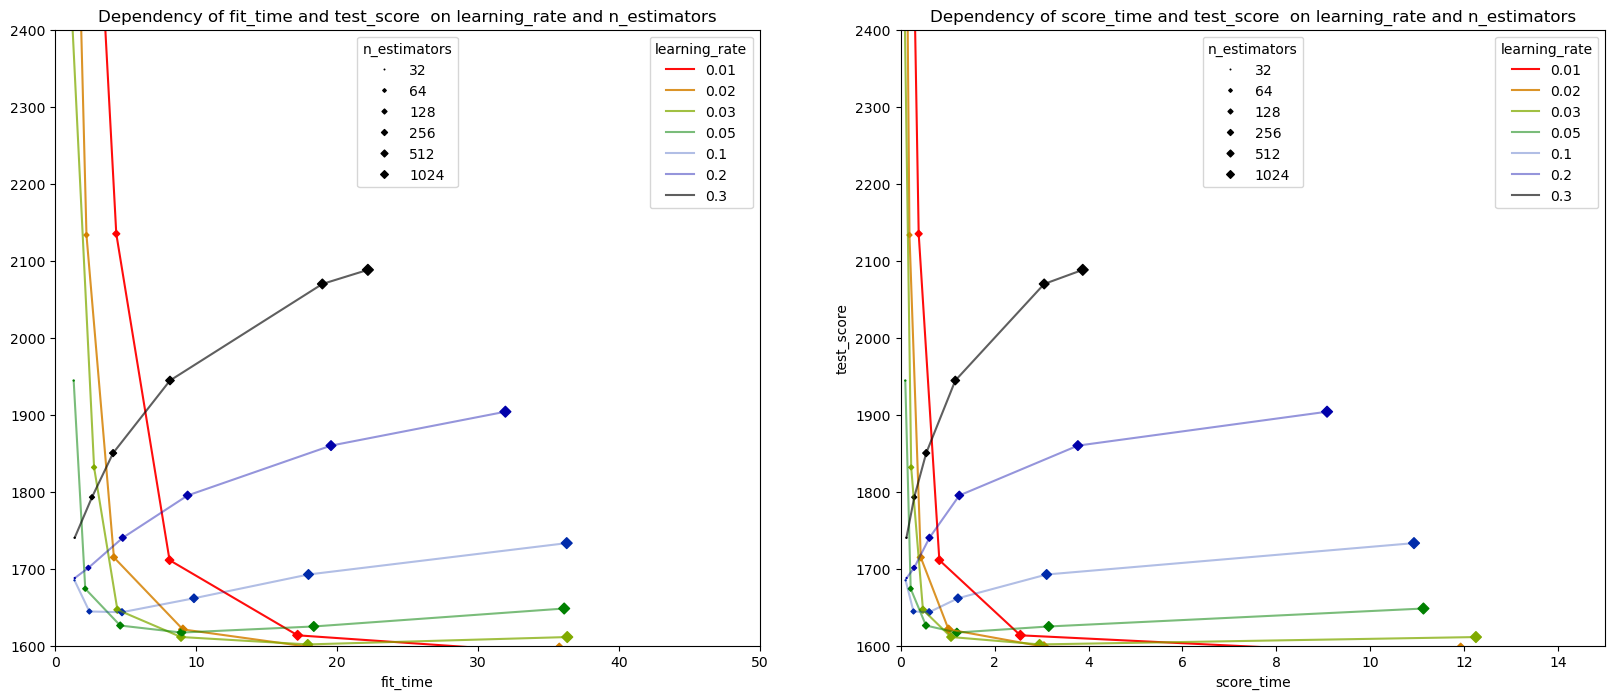

In [34]:
lgbm_figure(gbm_def,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При скоростях .1 и выше переобучение происходит при небольшом числе оценщиков  и оптимальная метрика не достигается
Скорости 0.01 и ниже видимо позволяют достичь наилучщих метрик, но улучшение ожидается небольшое (<100) в то время как скорости обучения/ предсказания быстро растут
Оптимальны скорости обучения .02-.05

### GOSS

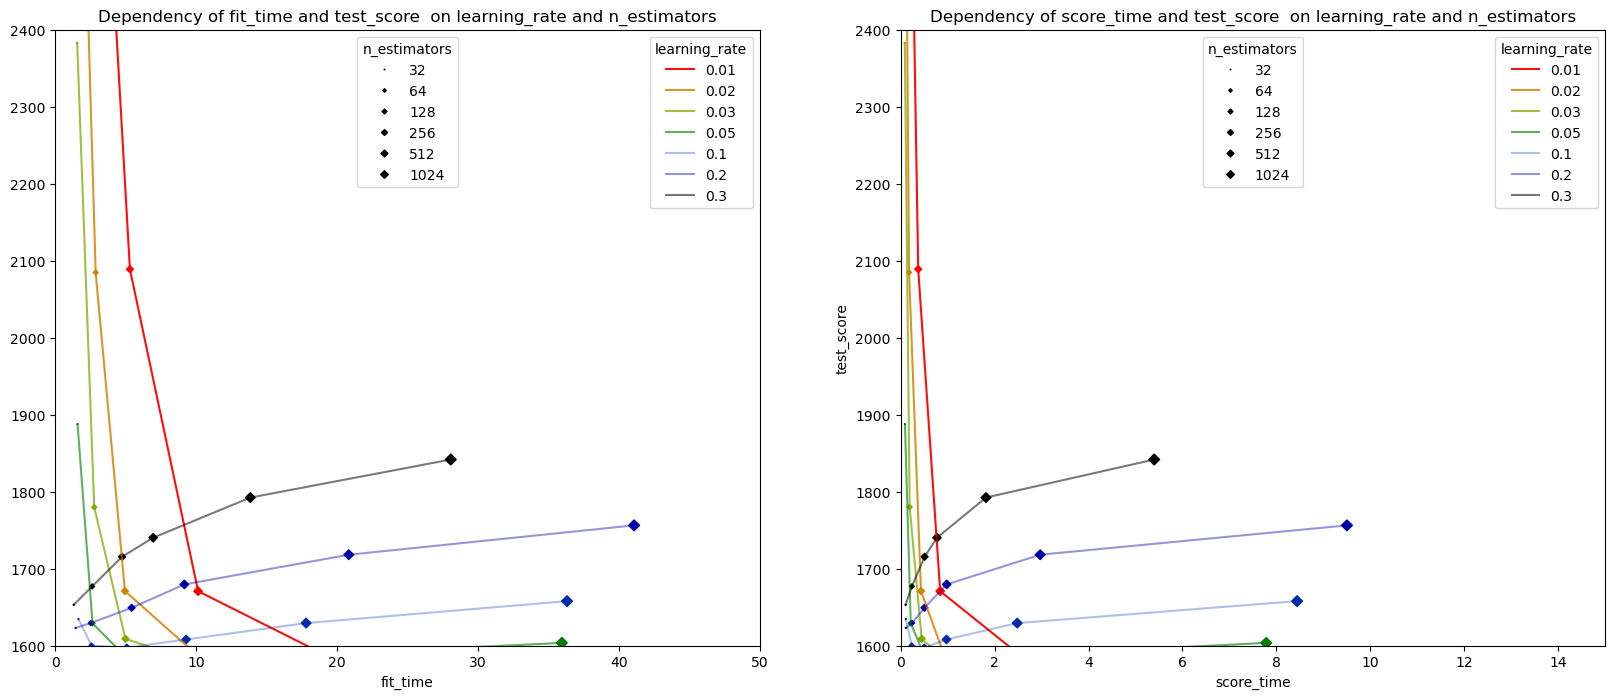

In [35]:
lgbm_figure(gbm_goss,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

Для goss в целом примерно та же картина, но время предсказания несколько меньше
Оптимальными я считаю параметры  learning_rate 0.02-0.05 и n_estimators = 512

### DART

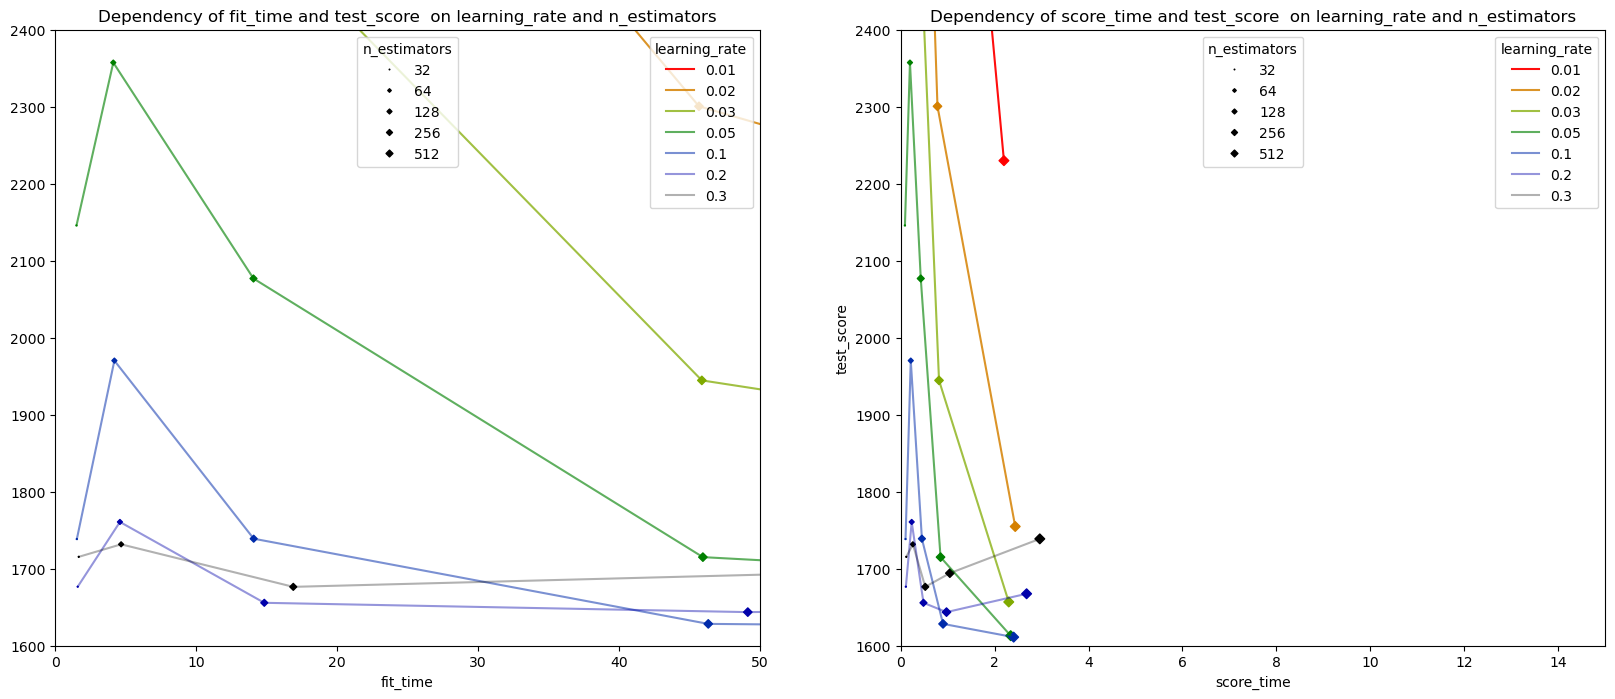

In [36]:
lgbm_figure( gbm_dart,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate' )  

Для darts примерно те же результаты при значительно большем времени обучения.  
Время предсказания внешне выглядит лучше, но только потому, что опущена последняя серия (n_est=1024) из-за очень большого времени обучения 

### Random Forest

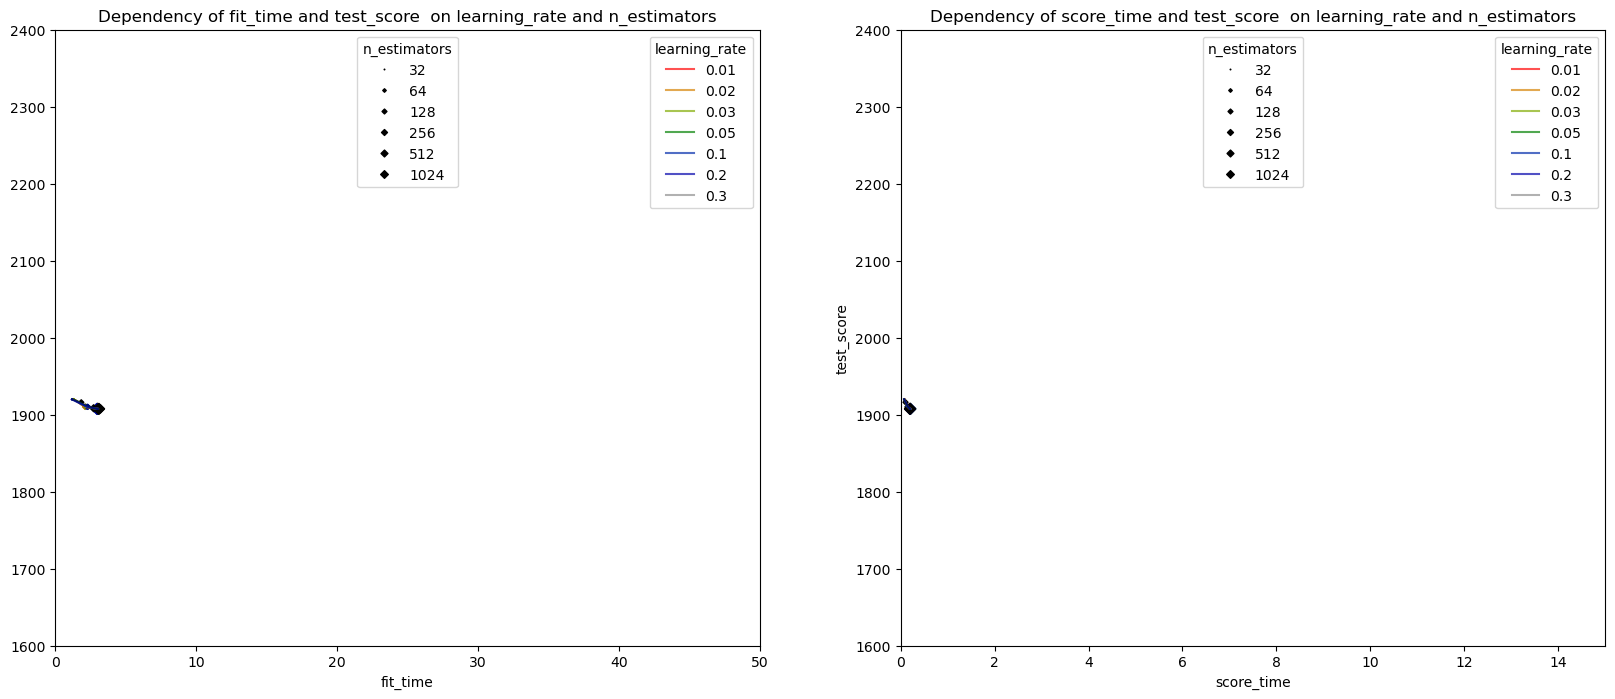

In [37]:
lgbm_figure(gbm_rf,['fit_time','score_time'],['test_score'],along='n_estimators',through='learning_rate')

При RandomForest результаты получились очень плотные и быстрые, но существенно больше ошибка 

### Структура деревьев

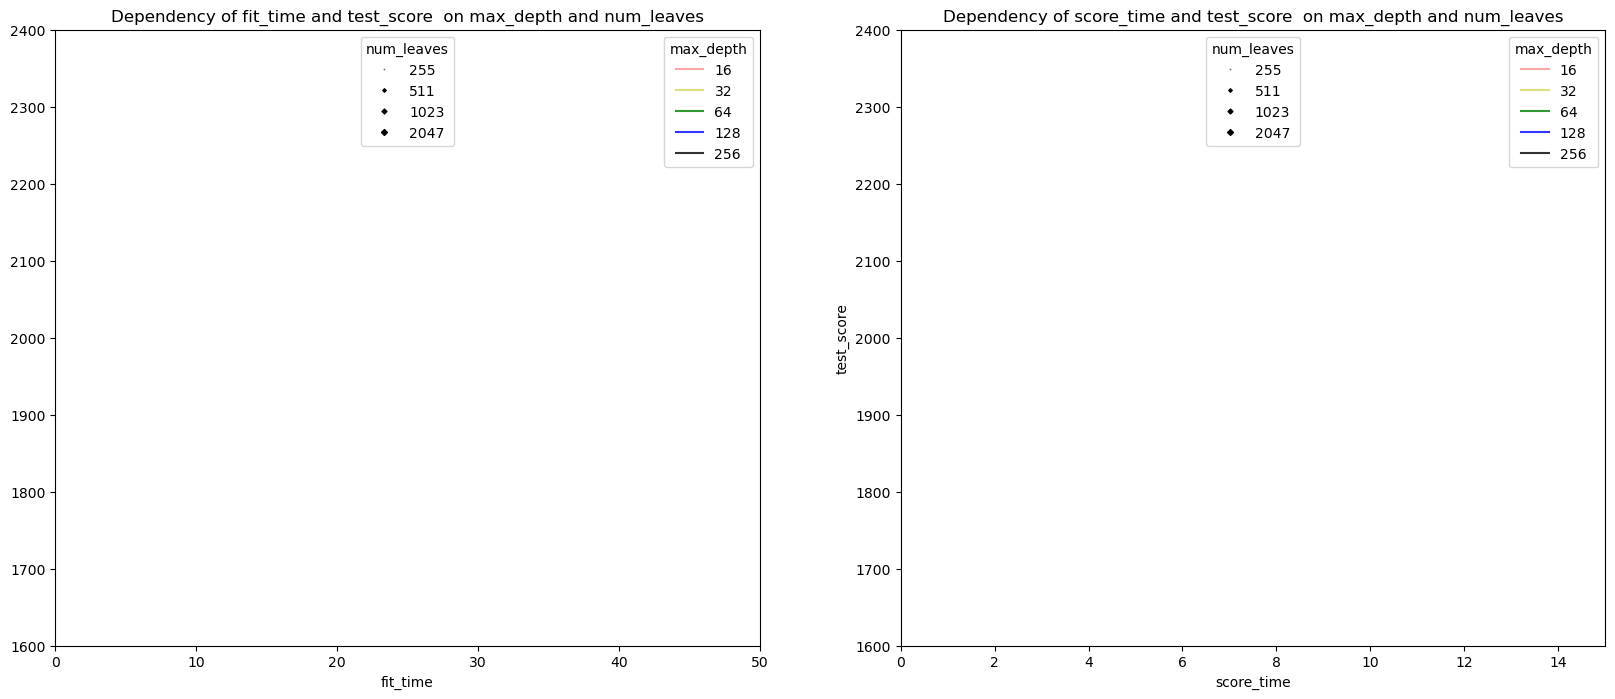

In [38]:
lgbm_figure( gbm_tree,['fit_time','score_time'],['test_score'],along='num_leaves',through='max_depth' )  

Структура дерева практически не влияет на метрику, ну увелечение количества листьев увеличивает время предсказания, по крайней мере для GOSS

### Final test

In [39]:
%%time
start = ti.default_timer()
model = lgb.LGBMRegressor( boosting='goss',objective='l2',learning_rate='.02',n_estimators = 512 
                              , max_depth=64, num_leaves=255)

model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)],eval_metric=['rmse'],callbacks=cbf)
step_1 = ti.default_timer()
a = model.predict(X_te)
finish = ti.default_timer()


[50]	training's rmse: 2343.89	training's l2: 5.49382e+06
[100]	training's rmse: 1729	training's l2: 2.98945e+06
[150]	training's rmse: 1565.37	training's l2: 2.45039e+06
[200]	training's rmse: 1503.16	training's l2: 2.25948e+06
[250]	training's rmse: 1466.31	training's l2: 2.15008e+06
[300]	training's rmse: 1439.32	training's l2: 2.07164e+06
[350]	training's rmse: 1416.69	training's l2: 2.00702e+06
[400]	training's rmse: 1396.73	training's l2: 1.95085e+06
[450]	training's rmse: 1378.92	training's l2: 1.90141e+06
[500]	training's rmse: 1362.88	training's l2: 1.85745e+06
Did not meet early stopping. Best iteration is:
[512]	valid_0's rmse: 1134.93	valid_0's l2: 1.28806e+06
CPU times: total: 51.1 s
Wall time: 13.8 s


In [40]:
print(f"R2: {round(r2(y_te,a),4)}\tRMSE: {round(rmse(y_te,a))}")
print(f"Время обучения {round(step_1-start,1)} сек \tвремя предсказания {round(finish-step_1,1)} cек")

R2: 0.8799	RMSE: 1580
Время обучения 11.8 сек 	время предсказания 2.0 cек


### Вывод

Проведено тестирование и сравнение моделей градиентного бустинга с алгоритмами gbdt,dart, goss с классической моделью RandomForest.
* все GB модели превосходят по точности RandomForest, хотя требуют больше времени
* результаты тестов GBM стабильны и более-менее одинаковы, с небольшим превосходством GOSS
* при скоростях обучения больше 0.1 эти модели переобучаются до достижения оптимальной точности
* при скоростях обучения меньше 0.01 время обучения быстро растет без существенного улучшения точности

При обучении модели предсказания цен рекомендуется использовать алгоритм GOSS  
с гиперпараметрами -   
* n_estimators ~ 500   
* learning_rate  0.02   
* num_leaves - до 250   
При этом ожидаемая ошибка предсказания - до 1600   
время обучения - до 15 с, время предсказания до 3 с 
